In [1]:
import torch as th 
import torch.nn.functional as F
from PIL import Image 
from pathlib import Path 
import matplotlib.pyplot as plt 
import numpy as np 

c:\Users\yogam\projects\image-recognition\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [116]:
def display_mutiple(
    max_cols: int, 
    images: list[th.Tensor], 
    titles: list[str] | None = None,
    cmaps: list[str | None] | str="gray", 
    figsize: tuple[int, int]=(10, 10)
) -> None:
    if isinstance(cmaps, list):
        assert len(cmaps) == len(images)
    else:
        cmaps = [cmaps] * len(images)
    if isinstance(titles, list):
        assert len(titles) == len(images)
    else:
        titles = [""] * len(images)

    rows = 1 + len(images)//max_cols

    fig = plt.figure(figsize=figsize)
    for i, (img, cmap, title) in enumerate(zip(images, cmaps, titles)):
        fig.add_subplot(rows, max_cols, i + 1)
        plt.axis('off')
        plt.title(title)
        plt.imshow(img.permute(1, 2, 0), cmap=cmap)


def min_max_scaling(data: th.Tensor) -> th.Tensor:
    return (data - data.min()) / (data.max() - data.min())

def conv2d(img: th.Tensor, kernel: th.Tensor, *args, stride=None, padding=None, **kwargs) -> th.Tensor:
    """normal F.conv2d, but with custom padding (because F.conv2d do not support 'replicate' mode"""
    pad_h = kernel.shape[-2] // 2
    pad_w = kernel.shape[-1] // 2
    padded = F.pad(img, (pad_w, pad_w, pad_h, pad_h), mode="replicate")
    return F.conv2d(padded, kernel, stride=1, *args, **kwargs)


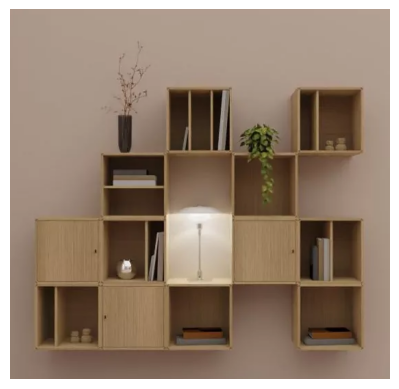

In [100]:
img_path = Path(__name__).absolute().parent / "furniture.png"
img = th.Tensor(plt.imread(img_path))
img = th.moveaxis(img, -1, 0)

plt.axis("off")
plt.imshow(img.permute(1, 2, 0))

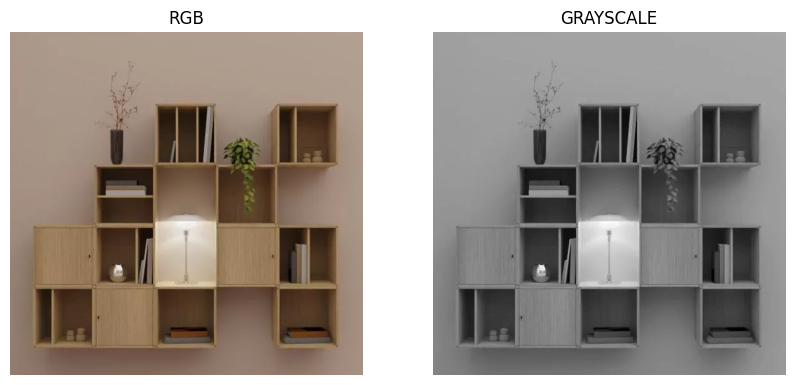

In [101]:
def th_to_grayscale(img: th.Tensor) -> th.Tensor:
    kernel = th.Tensor([[[0.2989]], [[0.5870]], [[0.1140]]]) 
    kernel = kernel.expand((1, 3, 1, 1)) # out channels, in channels, h, w
    img_grayscale = F.conv2d(img, kernel)
    
    return img_grayscale

gray_img = th_to_grayscale(img)

assert gray_img.shape[1:] == img.shape[1:]

display_mutiple(2, [img, gray_img], cmaps=[None, "gray"], titles=["RGB", "GRAYSCALE"])

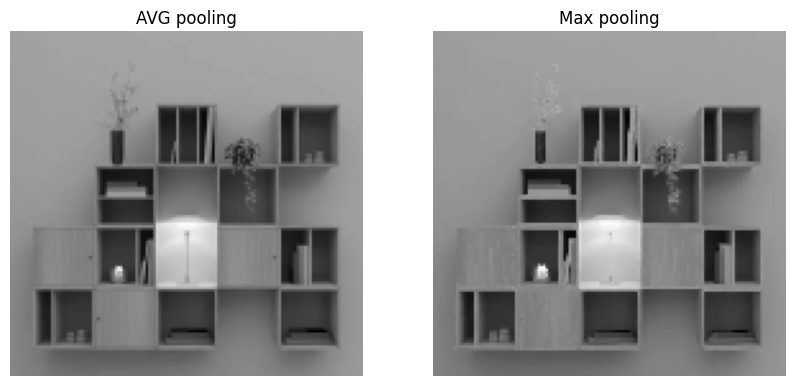

In [102]:
K = 4

img_maxpool = F.max_pool2d(gray_img, K)
img_avgpool = F.avg_pool2d(gray_img, K)

display_mutiple(2, [img_avgpool, img_maxpool], cmaps="gray", titles=["AVG pooling", "Max pooling"], figsize=(10, 20))

torch.Size([1, 139, 142]) torch.Size([1, 135, 138])


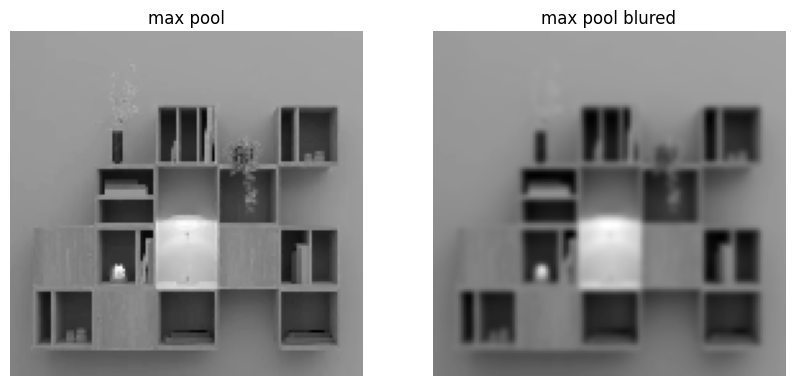

In [398]:
import math


def gaussian_kernel(kernel_size: int, sigma: float) -> th.Tensor:
    x_cord = th.arange(kernel_size)
    x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = th.stack([x_grid, y_grid], dim=-1)
    mean = (kernel_size - 1)/2.
    variance = sigma**2.
    gaussian_kernel = (
        (1./(2.*math.pi*variance)) \
        * th.exp(
            -th.sum((xy_grid - mean)**2., dim=-1) /\
            (2*variance)
        )
    )
    gaussian_kernel = gaussian_kernel / th.sum(gaussian_kernel)
    return gaussian_kernel


KERNEL_SIZE = 5
SIGMA = 1
kernel = gaussian_kernel(KERNEL_SIZE, SIGMA).expand(1, 1, KERNEL_SIZE, KERNEL_SIZE)

max_blurred = conv2d(img_maxpool, kernel) 

assert img_avgpool.shape == max_blurred.shape, (img_avgpool.shape, max_blurred.shape)

display_mutiple(2, [img_maxpool, max_blurred], titles=["max pool", "max pool blured"], figsize=(10, 10))

torch.Size([1, 137, 140]) torch.Size([1, 135, 138])


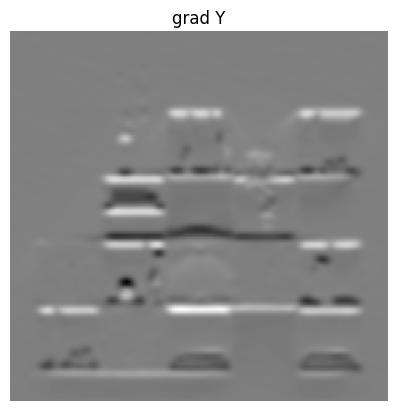

torch.Size([1, 137, 140]) torch.Size([1, 135, 138])


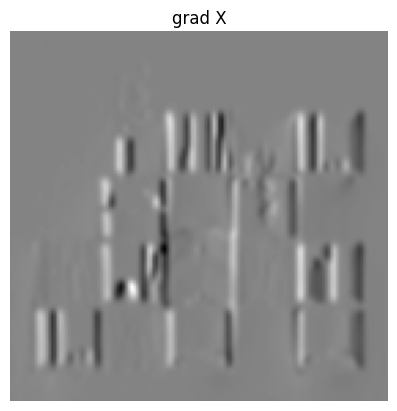

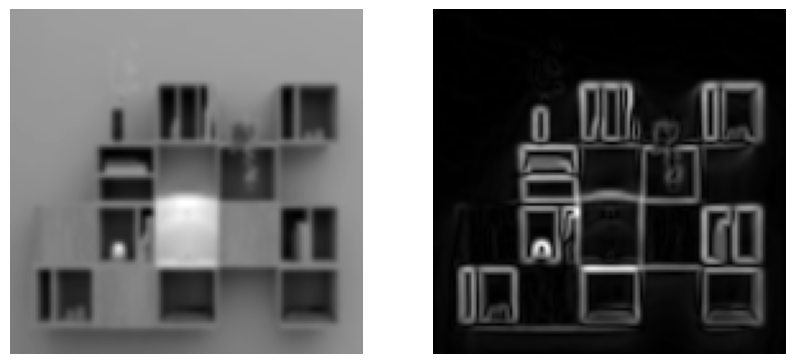

In [406]:
def get_gradients(img: th.Tensor) -> th.Tensor:
    def __conv(kernel, img) -> th.Tensor:
        kernel = kernel.expand((1, 1, 3, 3))
        return conv2d(img, kernel)

    sobel_y = th.Tensor([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    grad_y = __conv(sobel_y, img)
    grad_x = __conv(sobel_y.t(), img)
    return th.sqrt(grad_y ** 2 + grad_x ** 2)

gradients = get_gradients(max_blurred)

display_mutiple(2, [max_blurred, gradients])

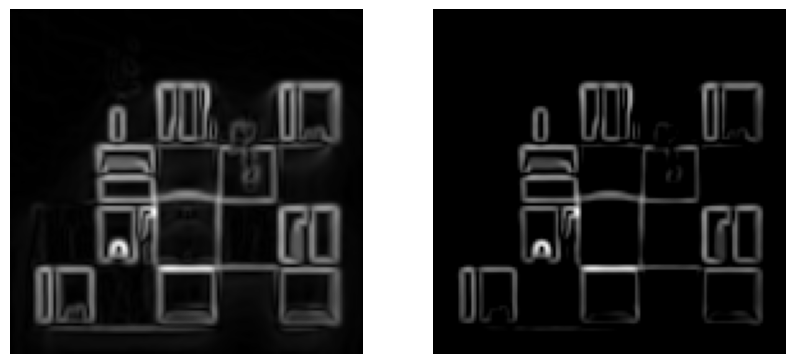

In [400]:
THRESH = 0.3
gradients_thresh = F.relu(gradients - THRESH) + THRESH
final = min_max_scaling(gradients_thresh)

display_mutiple(2, [gradients, final])

## Hough transform

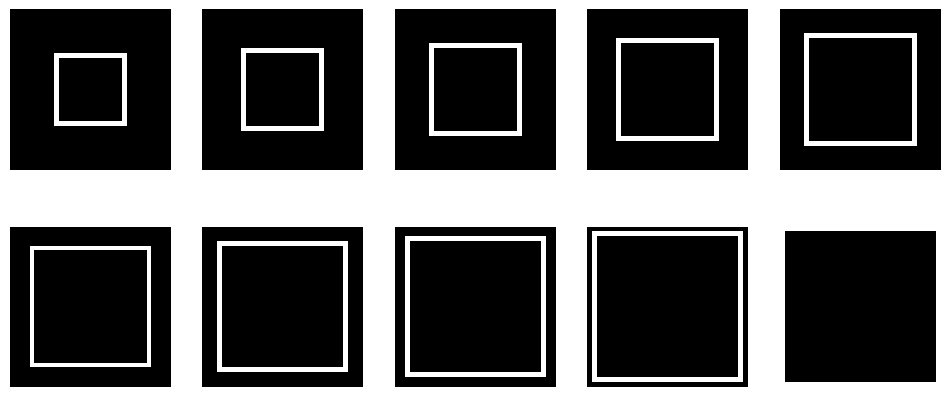

In [401]:
def get_hough_kernel(low: int, high: int) -> th.Tensor:
    assert low % 2 == 1 and high % 2 == 1, "both high and low must be odd"
    kernels = []
    for i in range(low, high + 1, 2):
        # crop square of 0's from the middle of the tensor layer 
       kernel = np.zeros((high, high))
       offset = (high - i) // 2
       kernel[offset: offset + i, offset: offset + i] = 1
       kernel[offset + 1: offset + i - 1, offset + 1: offset + i - 1] = 0
       assert kernel.sum().sum() == 4*i - 4, (kernel.sum().sum(), 2*i + 2* (i-1))
       kernels.append(kernel)
    return th.Tensor(kernels)

LOW, HIGH = 15, 33

k = get_hough_kernel(LOW, HIGH)

display_mutiple(5, k.unsqueeze(1), cmaps="gray", figsize=(12, 8))
hough_kernels = k.unsqueeze(0)

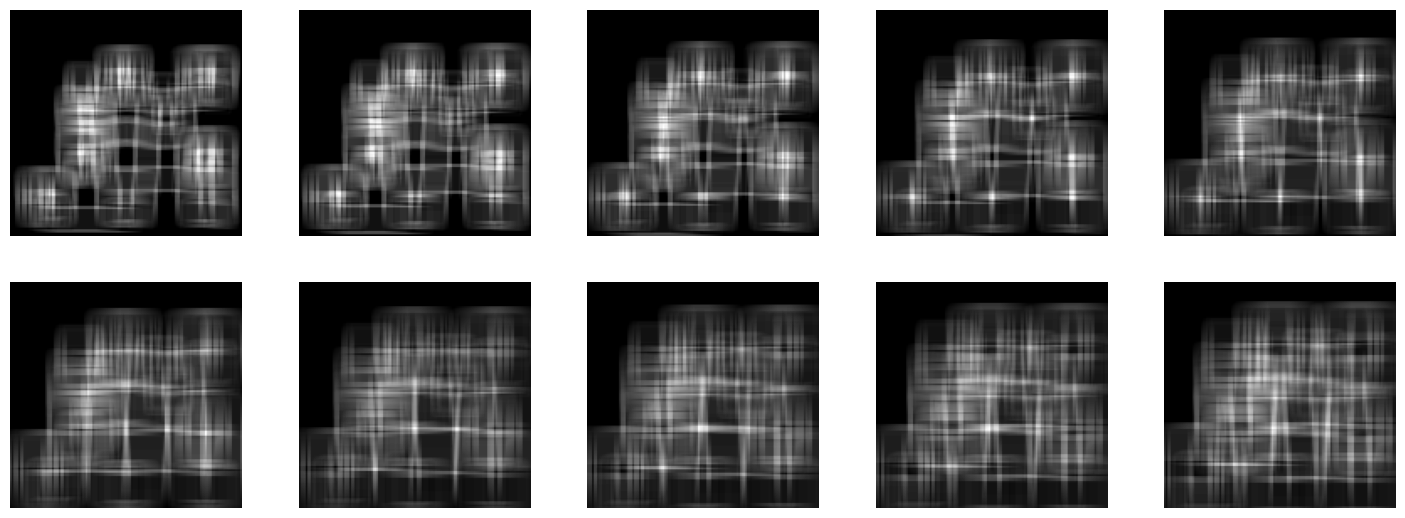

In [402]:
final_binary = th.Tensor(final)
final_binary[final_binary > 0] = 1

hough_space = F.conv_transpose2d(final, hough_kernels, padding=HIGH // 2)
hough_space = min_max_scaling(hough_space)
assert final.shape[1:] == hough_space.shape[1:], (final.shape[1:], hough_space.shape[1:])

display_mutiple(5, hough_space.unsqueeze(1), cmaps="gray", figsize=(18, 10))

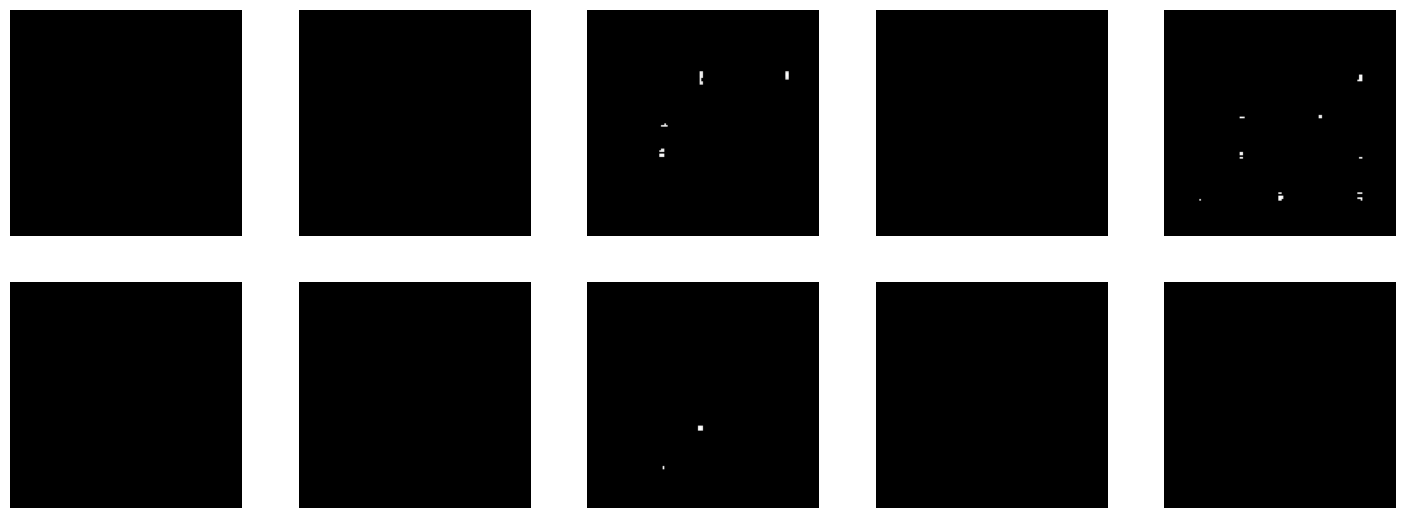

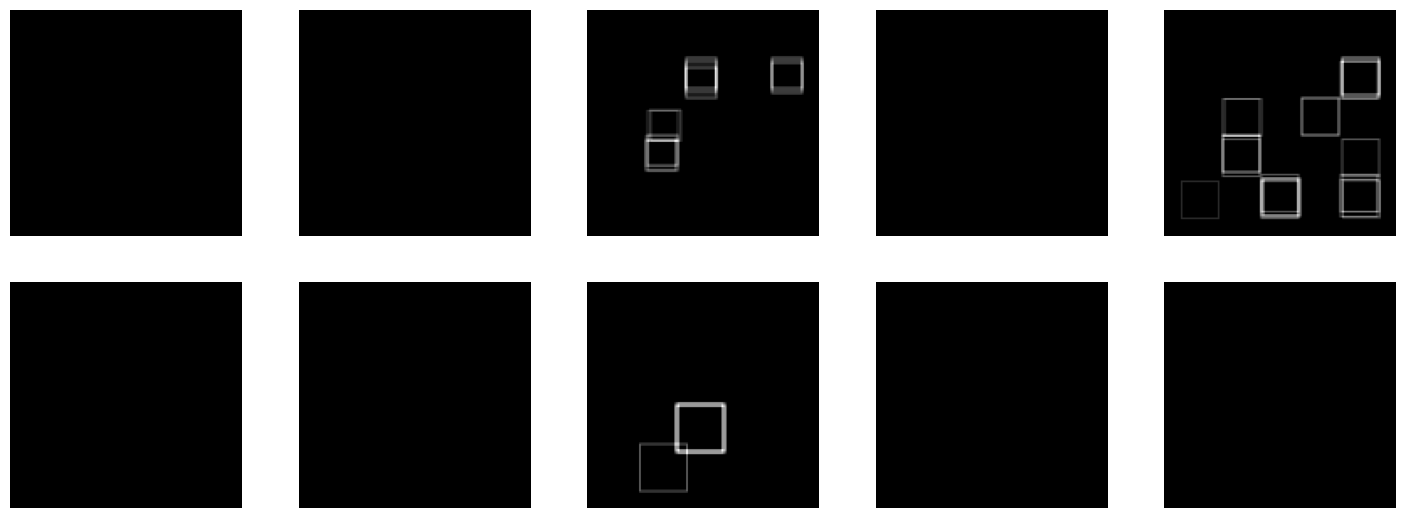

In [385]:
def hough_space2squares(hough_space, kernels) -> list[th.Tensor]:
    img_per_dim = []
    for i in range(hough_space.shape[0]):
        space = hough_space[i].unsqueeze(0)
        space_kernel = kernels.squeeze(0)[i].expand(1, 1, *kernels.shape[-2:])
        squares = F.conv_transpose2d(space, space_kernel, padding=HIGH // 2)
        img_per_dim.append(squares)
    return img_per_dim


HOUGH_THRESH = th.Tensor([[1], [1], [0.6], [0.8], [0.76], [1], [1], [0.85], [0.95], [1]])[..., None].expand(hough_space.shape)

hough_space_thresh = hough_space.clone()
hough_space_thresh[hough_space <= HOUGH_THRESH] = 0
squares_per_dim = hough_space2squares(hough_space_thresh, hough_kernels)
display_mutiple(5, hough_space_thresh.unsqueeze(1), cmaps="gray", figsize=(18, 10))
display_mutiple(5, squares_per_dim, cmaps="gray", figsize=(18, 10))

(-0.5, 554.5, 540.5, -0.5)

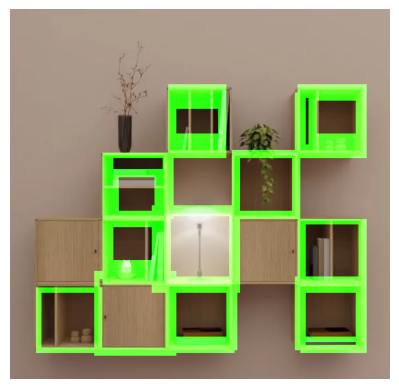

In [386]:
import torchvision.transforms as tm

def annotate(img, mask, channel) -> th.Tensor:
    assert img.shape[1:] == mask.shape
    img_cpy = img.clone()
    img_cpy[channel, mask > 0] = 1
    return img_cpy 

mask = th.stack(squares_per_dim).sum(dim=0)
mask_upsampled = tm.Resize(img.shape[1:])(mask).squeeze(0)
img_annotated = annotate(img, mask_upsampled, 1)

plt.imshow(img_annotated.permute(1, 2, 0))
plt.axis("off")